# 05.02 - MODEL EVALUATION

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources
endpoint https://m3g87w9l3k.execute-api.us-west-2.amazonaws.com/dev/rlxmooc


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import local.lib.timeseries as ts
from local.lib import calhousing as ch
%matplotlib inline

Loading BokehJS ...


## The [`cal_housing`](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) repository publicly available

In [2]:
!head local/data/cal_housing_small.data
!wc local/data/cal_housing_small.data

longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,medianHouseValue
-120.58,35.0,37.0,523.0,119.0,106300.0
-118.17,33.98,31.0,1236.0,329.0,155400.0
-122.22,37.81,52.0,1971.0,335.0,273700.0
-117.91,33.66,21.0,1708.0,505.0,193800.0
-121.92,37.24,27.0,1265.0,216.0,281200.0
-117.01,32.71,20.0,3506.0,692.0,129100.0
-116.39,34.15,15.0,5583.0,1149.0,73300.0
-120.67,35.5,15.0,2752.0,546.0,175000.0
-118.18,34.04,36.0,1807.0,630.0,129000.0
  501   501 20363 local/data/cal_housing_small.data


In [3]:
d = pd.read_csv("local/data/cal_housing_small.data")
print (d.shape)
d.head()

(500, 6)


,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,medianHouseValue
0,-120.58,35.00,37.0,523.0,119.0,106300.0
1,-118.17,33.98,31.0,1236.0,329.0,155400.0
2,-122.22,37.81,52.0,1971.0,335.0,273700.0
3,-117.91,33.66,21.0,1708.0,505.0,193800.0
4,-121.92,37.24,27.0,1265.0,216.0,281200.0


## Understand data

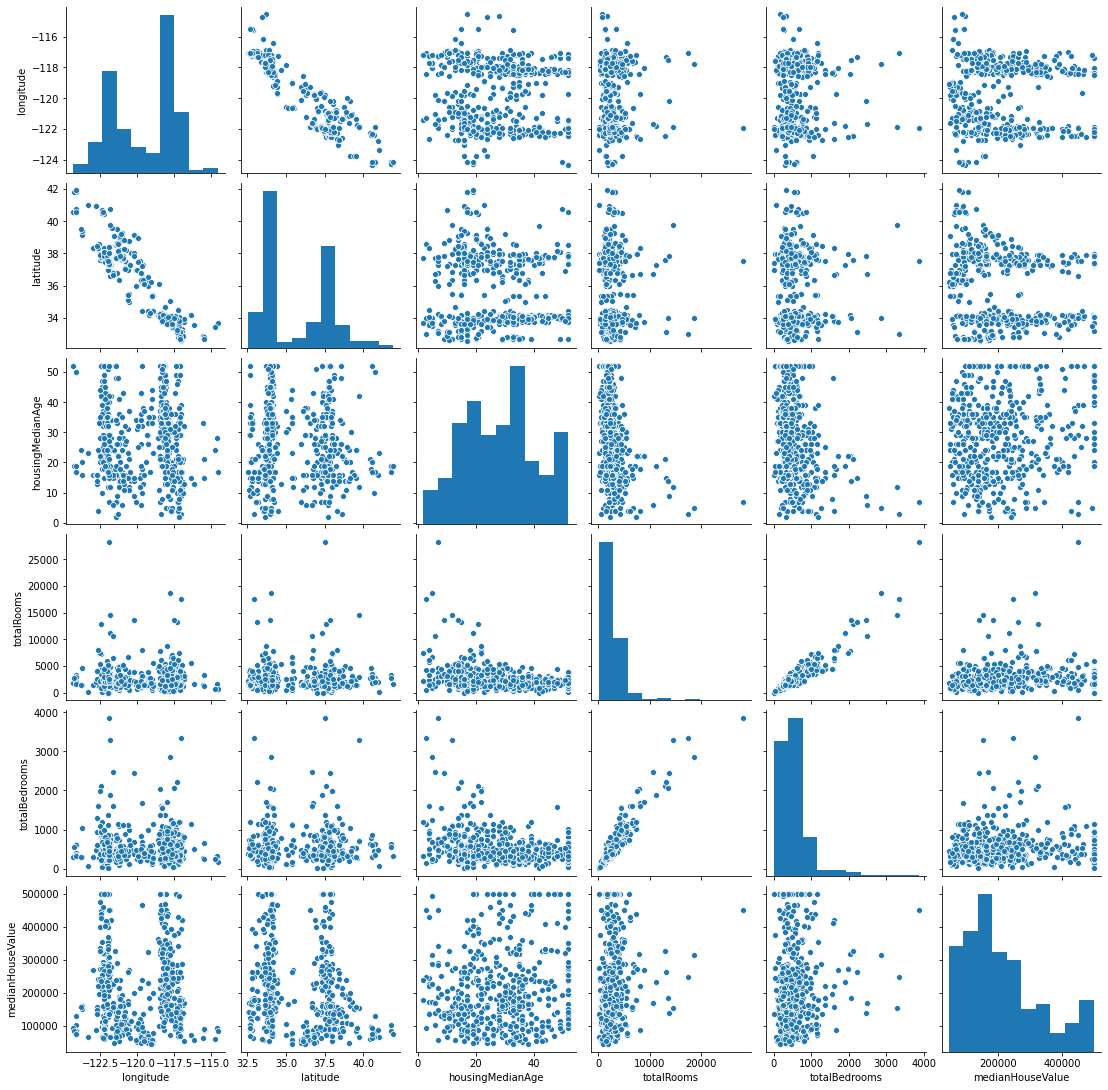

In [4]:
import seaborn as sns
g = sns.pairplot(d)


## Show house locations on map

observa como el valor de las casas es más caro en zonas urbanas

In [5]:
from bokeh.plotting import *
#from bokeh.charts import *
from bokeh.models import *
import bokeh
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

def latlng_to_meters(lat, lng):
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lng * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    return mx, my


def xplot_map(lat, lon, color=None, size=10):
    cmap = cm.rainbow
    wlat, wlong = latlng_to_meters(lat, lon)
    if color is not None:
        colors = MinMaxScaler(feature_range=(0,255)).fit_transform(color)
        colors = ["#%02x%02x%02x"%tuple([int(j*255) for j in cmap(int(i))[:3]]) for i in colors]

    openmap_url = 'http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'
    otile_url = 'http://otile1.mqcdn.com/tiles/1.0.0/sat/{Z}/{X}/{Y}.jpg'

    TILES = WMTSTileSource(url=openmap_url)
    tools="pan,wheel_zoom,reset"
    p = figure(tools=tools, plot_width=700,plot_height=600)

    p.add_tile(TILES)

    p.axis.visible = False

    cb = figure(plot_width=40, plot_height=600,  tools=tools)
    yc = np.linspace(np.min(color),np.max(color),20)
    c = np.linspace(0,255,20).astype(int)
    dy = yc[1]-yc[0]
    cb.rect(x=0.5, y=yc, color=["#%02x%02x%02x"%tuple([int(j*255) for j in cmap(int(i))[:3]]) for i in c], width=1, height = dy)
    cb.xaxis.visible = False
    p.circle(np.array(wlat), np.array(wlong), color=colors, size=size)
    pb = gridplot([[p, cb]])
    show(pb)

In [6]:
ds = d.sample(500)
xplot_map(ds["latitude"].values, 
         ds["longitude"].values, ds["medianHouseValue"].values.reshape(-1,1)/1e5) 

## Separate variable to predict

In [9]:
X = d.values[:,:-1]
y = d["medianHouseValue"].values
print (X.shape, y.shape)

(500, 5) (500,)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error

In [11]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3)
print (Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(350, 5) (350,) (150, 5) (150,)


## A linear regression

- check [sklearn LinearRegression doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to understand the `score` function.

In [12]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
lr.score(Xtr, ytr), lr.score(Xts, yts)

(0.32232366147227454, 0.307618752063642)

In [13]:
r2_score(yts, lr.predict(Xts))

0.307618752063642

In [14]:
median_absolute_error(yts, lr.predict(Xts))

55453.23499294184

In [15]:
mean_squared_error(yts, lr.predict(Xts))

10000399171.317457

**however we will create our score**

mean releative absolute error

In [16]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

In [17]:
rel_mrae(lr, Xtr, ytr), rel_mrae(lr, Xts, yts)

(0.482339200932234, 0.3994545505967154)

let's understand prediction errors

In [18]:
preds = lr.predict(Xts)
errors = np.abs(preds-yts)/yts

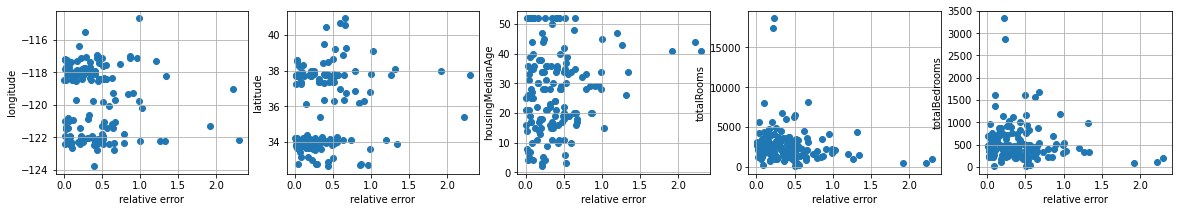

In [19]:
plt.figure(figsize=(20,3))
cols = ["longitude","latitude","housingMedianAge", "totalRooms","totalBedrooms"]
for i,col in enumerate(cols):
    plt.subplot(1,len(cols),i+1)
    plt.scatter(errors, Xts[:,i])
    plt.ylabel(col)
    plt.xlabel("relative error")
    plt.grid();

we observe there is no significant correlation between the error and any. It does seem that when the `houseMedianAge` is smaller, the error is also smaller, and when the `totalBedrooms` is higher the error is also smaller. However this seems to involve only a fraction of the houses. The correlation coefficients seems to capture this.



In [20]:
corrcoefs = pd.DataFrame([np.corrcoef(Xts[:,i], errors)[0,1] for i in range(len(cols))], index=cols, columns=["corrcoef"])
corrcoefs


,corrcoef
longitude,-0.109087
latitude,0.172464
housingMedianAge,0.143974
totalRooms,-0.140183
totalBedrooms,-0.106749


## How sure can we be of our model performance

resample, train and measure

- **bootstrap**: resample and put back
- **cross validation**: resample and partition

In [21]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size):
  trscores, tsscores = [], []
  for _ in range(10):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    estimator.fit(Xtr, ytr)
    trscores.append(rel_mrae(estimator, Xtr, ytr))
    tsscores.append(rel_mrae(estimator, Xts, yts))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [22]:
estimator = LinearRegression()
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))

train score 0.469 (±0.0097)
test score  0.452 (±0.0255)


**the `sklearn` library provides several validation methods**

**Bootstrapping**: data is sampled randomly at every split

In [23]:
from sklearn.model_selection import ShuffleSplit, KFold,cross_val_score

In [24]:
ss = ShuffleSplit(n_splits=3, test_size=0.3)

for a,b in ss.split(range(10)):
    print (a, b)

[6 5 1 8 4 7 0] [9 3 2]
[4 7 8 3 6 0 1] [2 9 5]
[1 0 7 4 9 5 6] [8 2 3]


In [25]:
z = cross_val_score(lr, X, y, cv = ShuffleSplit(n_splits=10, test_size=0.3), scoring=rel_mrae)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))


[0.47475243 0.4532451  0.45386072 0.47604051 0.48315741 0.57676936
 0.45063058 0.48636779 0.47881854 0.46195466]
test score  0.480 (±0.0347)


**Cross Validation**: data is partitioned

In [26]:
ss = KFold(n_splits=3)

for a,b in ss.split(range(10)):
    print (a, b)

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [27]:
z = cross_val_score(lr, X, y, cv = KFold(n_splits=10), scoring=rel_mrae)
print (z)
print ("test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))


[0.34715741 0.56105641 0.46435799 0.45752588 0.49913672 0.40221641
 0.50140556 0.41300136 0.61422836 0.45926731]
test score  0.472 (±0.0736)


assess the score with a **learning curve**

In [28]:
from sklearn.model_selection import ShuffleSplit

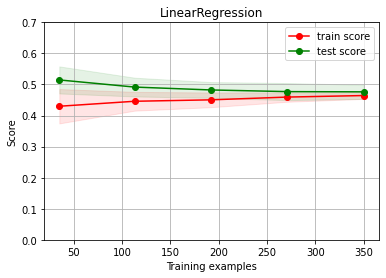

In [29]:
cv = ShuffleSplit(n_splits=10, test_size=.3)


ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, 
                       cv=cv, scoring=rel_mrae, ylim=(0,0.7))

## Diagnosing

**Linear regression BASELINE**

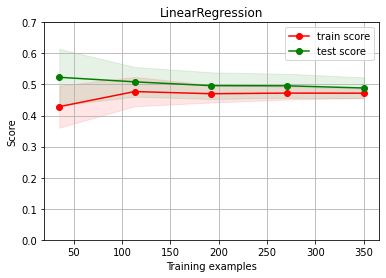

In [30]:
estimator = LinearRegression()
cv = ShuffleSplit(n_splits=10, test_size=.3)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7))

**We have UNDERFITTING (high bias)**
1. increase model complexity
2. get more columns

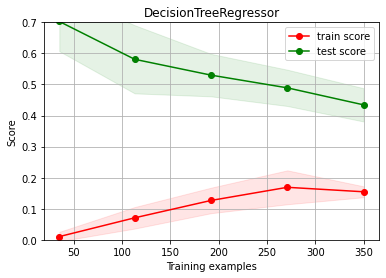

In [31]:
# try first increasing model complexity --> a bit better but with overfitting
# experiment with different max_depth values

from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor(max_depth=8)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7))

In [32]:
# try now with more columns (we have them!!!) --> improves a bit

d2 = pd.read_csv("local/data/cal_housing_small_full.data")
d2.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,medianHouseValue,population,households,medianIncome
0,-120.58,35.00,37.0,523.0,119.0,106300.0,374.0,95.0,1.4726
1,-118.17,33.98,31.0,1236.0,329.0,155400.0,1486.0,337.0,3.0938
2,-122.22,37.81,52.0,1971.0,335.0,273700.0,765.0,308.0,6.5217
3,-117.91,33.66,21.0,1708.0,505.0,193800.0,1099.0,434.0,3.2250
4,-121.92,37.24,27.0,1265.0,216.0,281200.0,660.0,232.0,5.3911


In [34]:
estimator = LinearRegression()
X2 = d2[[col for col in d2.columns if col!="medianHouseValue"]].values
y2 = d2["medianHouseValue"].values
print (X2.shape, y2.shape)

ch.plot_learning_curve(estimator, estimator.__class__.__name__, X2, y2, cv=cv, scoring=rel_mrae)

(500, 8) (500,)


## Diagnosing

**Random Forest BASELINE**


train score 0.158 (±0.0078)
test score  0.362 (±0.0226)


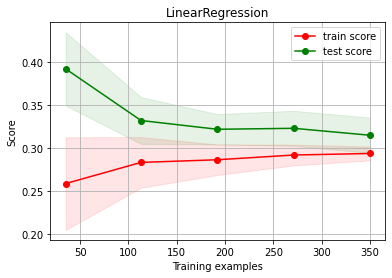

In [35]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor(max_depth=10)
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, X, y, test_size=0.3)
print ("train score %.3f (±%.4f)"%(trmean, trstd))
print ("test score  %.3f (±%.4f)"%(tsmean, tsstd))

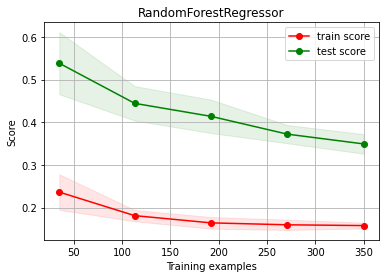

In [36]:
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

**We have OVERFITTING (high variance)**
- reduce model complexity
- get more data

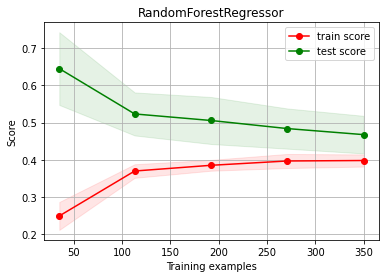

In [37]:
# try first reduce model complexity --> more BIAS
estimator = RandomForestRegressor(max_depth=4)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X, y, cv=cv, scoring=rel_mrae)

TOTAL AVAILABLE DATA (20640, 6)
building learning curve with (10000, 5) (10000,)


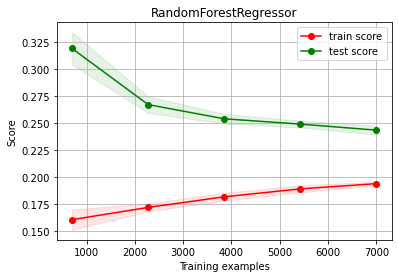

In [40]:
# try now with more data (we have A LOT!!!) 

d3 = pd.read_csv("local/data/cal_housing.data")
print ("TOTAL AVAILABLE DATA", d3.shape)
d3 = d3.sample(10000)
estimator = RandomForestRegressor(max_depth=10)
X3 = d3.values[:,:-1]
y3 = d3["medianHouseValue"].values
print ("building learning curve with", X3.shape, y3.shape)

ch.plot_learning_curve(estimator, estimator.__class__.__name__, X3, y3, cv=cv, scoring=rel_mrae)

## What if we made the wrong choice


- **Linear Regression** UNDERFITTING and choose acquire more data: No improvement!!!

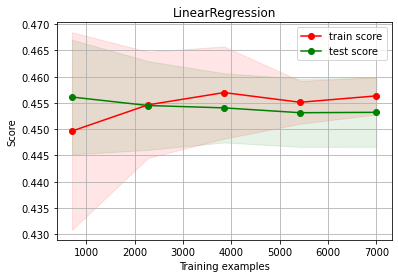

In [41]:
estimator = LinearRegression()
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X3, y3, cv=cv, scoring=rel_mrae)

- **Random Forest** OVERFITTING and choose to add more columns: some improvement!!!

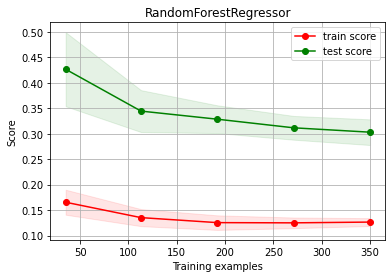

In [42]:
estimator = RandomForestRegressor(max_depth=10)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, X2, y2, cv=cv, scoring=rel_mrae)

- let's now choose more data and more columns (a luxury!!!)

TOTAL AVAILABLE DATA (20640, 9)
building learning curve with (10000, 8) (10000,)


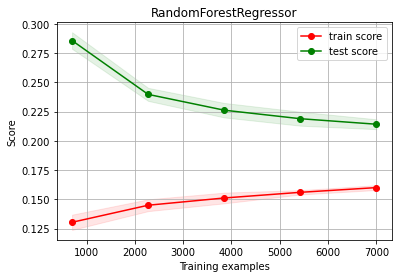

In [43]:
d4 = pd.read_csv("local/data/cal_housing_full.data")
print ("TOTAL AVAILABLE DATA", d4.shape)
d4 = d4.sample(10000)
estimator = RandomForestRegressor(max_depth=10)
X4 = d4.values[:,:-1]
y4 = d4["medianHouseValue"].values
print ("building learning curve with", X4.shape, y4.shape)

ch.plot_learning_curve(estimator, estimator.__class__.__name__, X4, y4, cv=cv, scoring=rel_mrae)